In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
import glob
from tqdm import tqdm
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2
from nibabel.viewers import OrthoSlicer3D
from nibabel import nifti1
import nibabel as nib

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
example_filename1='/Users/lixiang/nyu/2020 spring/Proj/data_new/training/training01/preprocessed/training01_01_flair_pp.nii'
example_filename1_mask='/Users/lixiang/nyu/2020 spring/Proj/data_new/training/training01/masks/training01_01_mask1.nii'

img1 = nib.load(example_filename1)
img1_mask=nib.load(example_filename1_mask)
img1=img1.get_fdata()
img1_mask=img1_mask.get_fdata()


In [4]:
img1=img1.astype('float32')/255.0
img1_mask=img1_mask.astype('uint8')


In [5]:
from random import choice
new_h, new_w = 100, 400
train_img_masks=[]
for i in tqdm(range(img1.shape[2])):
    img_resize1 = img1[:,:,i]
    mask_resize1 = np.uint8(img1_mask[:,:,i])
    train_img_masks.append((img_resize1, mask_resize1))
val_img_masks=random.sample(train_img_masks, 150)

100%|██████████| 181/181 [00:00<00:00, 87020.75it/s]


Text(0.5,1,'sample image')

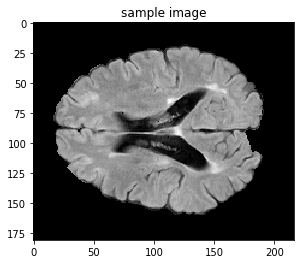

In [6]:
plt.imshow(train_img_masks[181//2][0], cmap = 'gray')
plt.title("sample image")

Text(0.5,1,'mask image')

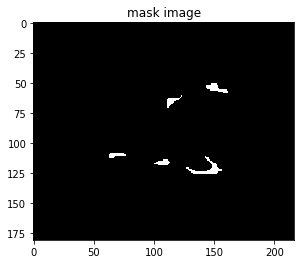

In [7]:
plt.imshow(train_img_masks[181//2][1], cmap = 'gray')
plt.title("mask image")

In [8]:

class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch,out_ch,3,padding=(1,1))
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm2d(out_ch)
        
    def forward(self, x):
        # define forward operation using the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        self.down = nn.MaxPool2d((2,2)) # use nn.MaxPool2d( )
    def forward(self, x):
        x = self.down(x)
        return x


# Note that this class will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up_layer(nn.Module):
    def __init__(self):
        super(up_layer, self).__init__()       
        self.up = nn.Upsample(scale_factor = 2, mode='bilinear') # use nn.Upsample() with mode bilinear
        # Note: after up, we also concatenate with previously saved feature x2

    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # First we upsample x1 to be same size as x2
        x1 = self.up(x1)
        

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        

        x = torch.cat([x2, x1], dim=1)
        
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch,out_ch,3,padding=(1,1))

    def forward(self, x):
        x = self.conv(x)
        x = torch.sigmoid(x)
        return x
    

In [9]:

import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super(UNet, self).__init__()
        self.inc = single_conv(n_channels_in, 16) 
        self.down1 = down_layer()
        self.conv1 = single_conv(16,32)
        self.down2 = down_layer()
        self.conv2 = single_conv(32,32)
        self.up1 = up_layer()
        self.conv3 = single_conv(64,16)  
        self.up2 = up_layer()
        self.conv4 = single_conv(32,16)                  

        self.outc = outconv(16,n_channels_out)                 

    def forward(self, x):

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x2 = self.conv1(x2)
        x3 = self.down2(x2)
        x3 = self.conv2(x3)

        x = self.up1(x3, x2)
        x = self.conv3(x)
        x = self.up2(x,x1)
        x = self.conv4(x)
        x = self.outc(x)
        return x
    

In [10]:

class DiceCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, prediction, target):
        self.save_for_backward(prediction, target)
        eps = 0.0001 # in case union = 0

        A = prediction.view(-1)
        B = target.view(-1)
        
        inter = torch.dot(A.float(),B.float())
        union = torch.sum(A.float()) + torch.sum(B.float()) - inter + eps

        d = inter / union
        return d



def dice_coeff(prediction, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()
    
    for i, (a,b) in enumerate(zip(prediction, target)):
        s += DiceCoeff().forward(a,b)
    s = s / (i + 1)
    return s


In [11]:

class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=1.0):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
           
            img_flip = img[:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 
        
        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = self.image_masks[index][0] # H, W, C
        mask = self.image_masks[index][1]
        
        image = np.transpose(image, axes=[2, 0, 1]) # C, H, W
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_img=[]
val_img=[]
for i in range(len(train_img_masks)):
    train_img.append((train_img_masks[i][0][:, : ,np.newaxis],train_img_masks[i][1][:, : ,np.newaxis]))
for i in range(len(val_img_masks)):
    val_img.append((val_img_masks[i][0][:, : ,np.newaxis],val_img_masks[i][1][:, : ,np.newaxis]))

train_dataset = CustomDataset(train_img, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img, transforms=transforms.Compose([Flip(),ToTensor()]))

In [12]:
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    for i, b in enumerate(dataset):
        img = b['img'].to(device)
        B = img.shape[0]
        true_mask = b['label'].to(device)
       
        mask_pred = net(img.float())
        
        # For all pixels in predicted mask, set them to 1 if larger than 0.5. Otherwise set them to 0
        mask_pred = mask_pred > 0.5
        
        
        #zero = torch.zeros_like(mask_pred)
        #one = torch.ones_like(mask_pred)
        
        #mask_pred = torch.where(mask_pred > 0.5, one, mask_pred)
        #mask_pred = torch.where(mask_pred <= 0.5, zero, mask_pred)
        
        # calculate dice_coeff()
        # note that you should add all the dice_coeff in validation/testing dataset together 
        # call dice_coeff() here
        tot += dice_coeff(true_mask,mask_pred)
        # Return average dice_coeff()
    return tot / (i + 1)

In [13]:

net = UNet(1,1)
net.to(device)  # run net.to(device) if using GPU
print(net)

# If continuing from previously saved model, run
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

UNet(
  (inc): single_conv(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down1): down_layer(
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv1): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down2): down_layer(
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (up1): up_layer(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
  )
  (conv3): single_conv(
    (

In [31]:

epochs = 3 # e.g. 10, or more until dice converge
batch_size = 1 # e.g. 16
lr = 0.01        # e.g. 0.01
N_train = len(train_img_masks)
model_save_path = './model/'  # directory to same the model after each epoch. 
aa=[]
bb=[]
cc=[]
optimizer = optim.SGD(net.parameters(),lr = lr,momentum=0.9, weight_decay=0.0005)

# The loss function w
criterion = nn.BCELoss()

for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    for i, b in enumerate(train_loader):

        # Get images and masks from each batch
        
        imgs = b['img'].to(device)
        #print(imgs.shape)
        true_masks = b['label'].to(device)


        
        masks_pred = net.forward(imgs.float())
#         masks_pred = nn.functional.interpolate(masks_pred, size=(80,100), mode='bilinear')
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        
        aa.append(masks_pred.squeeze(1)[0,:,:].detach().numpy())
        bb.append(imgs[0,0,:,:].float().numpy())
        
        
        masks_probs_flat = masks_pred.view(-1)
        true_masks_flat = true_masks.view(-1)

        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_probs_flat,true_masks_flat.float())
        #print(true_masks.shape)
        cc.append(true_masks[0,:,:,0].numpy())
        epoch_loss += loss.item()
        if count % 50 == 0:
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))
        count = count + 1
        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. 
        # These are accumulated into x.grad for every parameter x
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad.
        optimizer.step()
    
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    

    # Perform validation with eval_net() on the validation data
    val_dice = eval_net(net,train_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

    

Starting epoch 1/3.
0.0000 --- loss: 0.012415


/Users/lixiang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.2762 --- loss: 0.000531
0.5525 --- loss: 0.014882
0.8287 --- loss: 0.018019
Epoch finished ! Loss: 0.005375243954687095
Validation Dice Coeff: tensor([0.])
Checkpoint 1 saved !
Starting epoch 2/3.
0.0000 --- loss: 0.009119
0.2762 --- loss: 0.012639
0.5525 --- loss: 0.000233
0.8287 --- loss: 0.015832
Epoch finished ! Loss: 0.005149622626696429
Validation Dice Coeff: tensor([0.])
Checkpoint 2 saved !
Starting epoch 3/3.
0.0000 --- loss: 0.013040
0.2762 --- loss: 0.016104
0.5525 --- loss: 0.015230
0.8287 --- loss: 0.004566
Epoch finished ! Loss: 0.004978162695948009
Validation Dice Coeff: tensor([0.])
Checkpoint 3 saved !


In [15]:
len(train_img_masks)

181

In [16]:

def predict_img(net,full_img,out_threshold=0.5):
    # set the mode of your network to evaluation
    #net.eval()
    
    # convert from Height*Width*Channel TO Channel*Height*Width
    full_img = np.transpose(full_img,[2,0,1])
    
    # convert numpy array to torch tensor, normalize to range (0,1)
    X_img = torch.from_numpy(full_img).unsqueeze(0).to(device)
    #plt.imshow(X_img[0][0],cmap='gray')
    
    with torch.no_grad():
    
        output_img = net.forward(X_img.float())
        
        out_probs = output_img.squeeze(0).squeeze(0)
        #print(out_probs.numpy()[:,40])
        #plt.imshow(out_probs.numpy(),cmap='gray')
        # threshold the probability to generate mask: mask=1 if prob > out_threshold, set mask to uint8 
        out_mask_np = (out_probs>out_threshold).cpu().numpy().astype('uint8')
        

    # For all pixels in predicted mask, set them to 1 if larger than out_threshold. Otherwise set them to 0
#     return out_mask_np
    return out_mask_np


In [48]:
test_img = train_img_masks[70][0]
test_img_mask_ori=train_img_masks[70][1]



#img_resize = cv2.resize(test_img,(100,80))
img_resize = test_img[:, : ,np.newaxis]
#plt.imshow(img_resize[:,:,0],cmap='gray')
mask = predict_img(net=net,
                    full_img=img_resize,
                    out_threshold=0.4)
#print(sum(mask==0))
# Rescale the mask back to original image size

#mask =  cv2.resize(mask,(orig_shape[1],orig_shape[0]))

/Users/lixiang/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Text(0.5,1,'Predict_Mask')

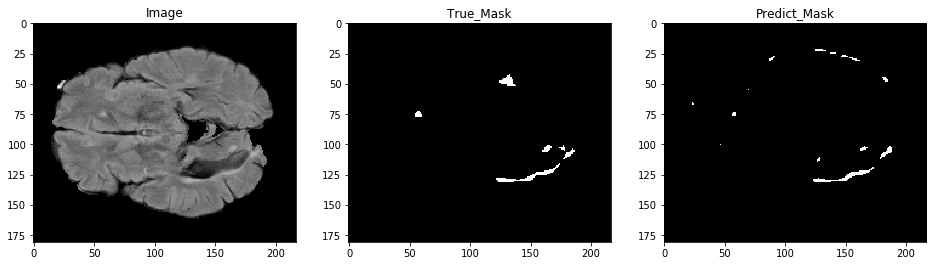

In [49]:
plt.figure(figsize = (16,48))
plt.subplot(1,3,1)
plt.imshow(test_img,cmap='gray')
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(test_img_mask_ori,cmap='gray')
plt.title('True_Mask')
plt.subplot(1,3,3)
plt.imshow(mask,cmap='gray')
plt.title('Predict_Mask')